In [266]:
import pandas as pd
import numpy as np
import random
from pprint import pprint
import sys
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import entropy
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)

COL_WIDTH=250
CMAP = 'seismic_r'
pd.options.display.max_colwidth = COL_WIDTH

EASY_THRESH = 0.75
MEDIUM_THRESH = 0.5
HARD_THRESH = 0.25
IMPOSSIBLE_THRESH = 0.0
ALPHA = 0.6

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# Loading pickled confidences

In [343]:
path = "/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/datamaps/test/datamap_test_subepoch_inference_elke_0.5_epochs/roberta-large/random/42/confidences.pickle"

df2 = pd.read_pickle(path)
sample_ids = list(df2.keys())


cartography_dict = {}

for sample_id in sample_ids:
    
    times_correct = []
    confidences = []
    
    outputs = df2[sample_id]
    
    outputs = outputs[1:] # don't count the first 0.5 epoch!
    
    for output in outputs:
        
        # extract values from output tuple
        prediction = output[0]
        label = output[1]
        
        # obtain GT confidence, determine correctness of prediction
        confidence = prediction[label]
        correct = 1 if prediction.index(max(prediction)) == label else 0
        
        # track confidence and correctness
        confidences.append(confidence)
        times_correct.append(correct)

    
    cartography_dict[sample_id] = {'confidence': np.mean(confidences),
                                  'variability': np.std(confidences),
                                  'correctness': np.mean(times_correct)}
    
    
#     print(sample_id, cartography_dict[sample_id])
        
        
    

confidences = [cartography_dict[key]['confidence'] for key in list(cartography_dict.keys())]
variability = [cartography_dict[key]['variability'] for key in list(cartography_dict.keys())]
correctness = [cartography_dict[key]['correctness'] for key in list(cartography_dict.keys())]

df = pd.DataFrame(list(zip(sample_ids, confidences, variability, correctness)), columns=['id', 'mean_conf', 'variability', 'correctness'])

# Code to read datasets

In [90]:
def read_dataset(input_dir, dataset_id, split, seed, wanli_id):
    """
    This function takes a dataset id and reads the corresponding .json split in an appropriate Pandas DataFrame
    :param wanli_id: id key for wanli json file (pairID for metrics, id for non metric stuff)
    :param seed:
    :param input_dir:
    :param dataset_id: str indicating which dataset should be read
    :param split: str indicating which split should be read
    :return: DataFrame with examples (Premise, Hypothesis, Label, ID)
    """
    # anli_rounds = ['ANLI_R1', 'ANLI_R2', 'ANLI_R3']
    anli_rounds = ['ANLI_R2', 'ANLI_R3']

    def replace_labels(label):
        label_conversions = {'e': 'entailment',
                             'c': 'contradiction',
                             'n': 'neutral'}

        return label_conversions[label]

    if dataset_id == 'SNLI':

        # TODO only consider snli with gold labels?
        data_path = '{}/snli_1.0/snli_1.0_{}.jsonl'.format(input_dir, split)
        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['sentence1', 'sentence2', 'gold_label', 'pairID']]
        dataset['dataset'] = 'SNLI'
        dataset = dataset.drop(dataset[dataset.gold_label.str.contains('-')].index)  # drop examples with no gold label

    # load separate ANLI rounds
    elif dataset_id in anli_rounds:

        data_round = dataset_id[-2:]  # extract the 'R#' substring from the provided ID
        data_path = '{}/anli_v1.0/{}/{}.jsonl'.format(input_dir, data_round, split)
        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['context', 'hypothesis', 'label', 'uid']]  # get rid of unnecessary columns
        dataset['label'] = dataset['label'].apply(replace_labels)  # ensures consistently named labels
        dataset['dataset'] = 'ANLI_{}'.format(data_round)
        #
        # print('Dataframe for {} - {}'.format(dataset_id, split), flush=True)

    # compile all ANLI rounds
    elif dataset_id == 'ANLI':

        dataset_list = []
        for data_round in anli_rounds:
            data_round = data_round[-2:]
            data_path = '{}/anli_v1.0/{}/{}.jsonl'.format(input_dir, data_round, split)
            dataset = pd.read_json(data_path, lines=True)
            dataset = dataset[['context', 'hypothesis', 'label', 'uid']]  # get rid of unnecessary columns
            dataset['label'] = dataset['label'].apply(replace_labels)  # ensures consistently named labels
            dataset['dataset'] = 'ANLI'
            dataset_list.append(dataset)
        dataset = pd.concat(dataset_list, axis=0)

    # Load MNLI
    elif dataset_id == 'MNLI':

        if split == 'train':
            data_path = '{}/multinli_1.0/multinli_1.0_{}.jsonl'.format(input_dir, split)
        elif split == 'dev' or split == 'test':
            data_path = '{}/multinli_1.0/multinli_1.0_dev_matched.jsonl'.format(input_dir)

        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['sentence1', 'sentence2', 'gold_label', 'pairID']]
        dataset['dataset'] = 'MNLI'
        dataset = dataset.drop(dataset[dataset.gold_label.str.contains('-')].index)

        # split dev into dev and test set
        if split == 'dev':
            dataset = dataset.sample(frac=1,  # reshuffle all rows in the dataframe prior to split
                                     random_state=seed)  # seed is fixed such that dev and test set are always the same
            dataset = dataset[:int((len(dataset)/2))]

        elif split == 'test':
            dataset = dataset.sample(frac=1,
                                     random_state=seed)
            dataset = dataset[int((len(dataset)/2)):]

    # Load WANLI
    elif dataset_id == 'WANLI':

        if split == 'train':
            data_path = '{}/wanli/train.jsonl'.format(input_dir)
        elif split == 'dev' or split == 'test':
            data_path = '{}/wanli/test.jsonl'.format(input_dir)

        dataset = pd.read_json(data_path, lines=True)
        dataset = dataset[['premise', 'hypothesis', 'gold', wanli_id]]
        dataset['dataset'] = 'WANLI'
        dataset = dataset.drop(dataset[dataset.gold.str.contains('-')].index)

        # split dev into dev and test set
        if split == 'dev':
            dataset = dataset.sample(frac=1,  # reshuffle all rows in the dataframe prior to split
                                     random_state=seed)  # seed is fixed such that dev and test set are always the same
            dataset = dataset[:int((len(dataset) / 2))]

        elif split == 'test':
            dataset = dataset.sample(frac=1,
                                     random_state=seed)
            dataset = dataset[int((len(dataset) / 2)):]

    else:
        raise KeyError('No dataset found for "{}"'.format(dataset_id))

    # ensure consistent headers per dataset DataFrame
    dataset.columns = ['Premise', 'Hypothesis', 'Label', 'ID', 'Dataset']

    dataset['ID'] = dataset['ID'].astype('string')

    return dataset

In [91]:
INPUT_DIR='/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/resources/ard_data'
SPLIT='train'
SEED=42
WANLI_ID='pairID'

def read_source(dataset_id):
    dataset = read_dataset(input_dir=INPUT_DIR, 
                 dataset_id=dataset_id, 
                 split=SPLIT, 
                 seed=SEED, 
                 wanli_id=WANLI_ID)
    return dataset

# Loading all datasets into their own DataFrame

In [5]:
snli = read_source('SNLI')
anli = read_source('ANLI')
wanli = read_source('WANLI')

# Code for Generating Datamaps for Different Sources / Strategies

In [353]:
def generate_df(dataframe):
    X = dataframe['variability'].tolist()
    Y = dataframe['mean_conf'].tolist()
    colors = dataframe['correctness'].tolist()

    plt.figure(figsize=(30, 10))
    plt.scatter(x=X, y=Y, c=colors, alpha=1, cmap=mpl.cm.get_cmap(CMAP))
    plt.xlim(0,0.5)
    plt.ylim(0,1)
    plt.xlabel('Variability')
    plt.ylabel('Confidence')
    plt.legend()
    plt.show()
    
def generate_strategy_map(base_df, strategy):
    path = "/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/acquisition_IDs/array/OOD_MNLI_active_learning_array_donderdag/roberta-large/{}/42/acquisition_ids.csv".format(strategy)
    acquired_df = pd.read_csv(path)

    ids = acquired_df.ID[:4000]

    acquired_df = base_df[base_df.id.astype('string').isin(ids)]
    generate_df(acquired_df)
    
def load_strategy_acquisitions(strategy, cap=4000, seed=42):
    
    path = "/Users/ardsnijders/Documents/GitHub/Lisa/active_learning/results/ard_output_dir_results/acquisition_IDs/array/OOD_MNLI_active_learning_array_donderdag/roberta-large/{}/{}/acquisition_ids.csv".format(strategy, seed)
    acquired_df = pd.read_csv(path)
    acquired_df = acquired_df[:cap]
    acquired_df['Name'] = strategy.capitalize()
    
    return acquired_df
    
def generate_source_map(base_df, source_df):

    ids = source_df.ID

    source_df = base_df[base_df.id.astype('string').isin(ids)]
    
    print('num of source in base: {}'.format(len(source_df)))
    
    generate_df(source_df)
    
def datamap_subset(base_df, source_df, name=None):
    
    source_ids = source_df.ID
    
    subset_df = base_df[base_df.id.astype('string').isin(source_ids)]

    if name is not None:
        subset_df['Name'] = name
    else:
        subset_df['Name'] = source_df.Dataset.tolist()[0]
    
    return subset_df

def generate_dfs_2(dataframe, markers=None, size=40, n_bins=10, font_size=20):
    
    plt.rcParams.update({'font.size': font_size})
    
    def generate_hist(axis, data, name, color, colormap, n_bins=10):
        
        cmap = False
        if color == 'cmap':
            cmap = True
            color = 'green'
        
        n, bins, patches = axis.hist(data, 
                                     n_bins, 
                                     weights=np.ones(len(data)) / len(data), 
                                     density=False, 
                                     color=color)

        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        
        if cmap:
        
            # scale values to interval [0,1]
            col = bin_centers - min(bin_centers)
            col /= max(col)

            for c, p in zip(col, patches):
                plt.setp(p, 'facecolor', colormap(c))

        axis.set_xlabel(name)
#         axis.set_ylabel('Percentage')
        axis.set_ylim(0,1)

        axis.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    
    # creating grid for subplots
    fig = plt.figure()
    fig.set_figheight(size)
    fig.set_figwidth(size)

    ax1 = plt.subplot2grid(shape=(4, 4), loc=(0, 0), colspan=3, rowspan=4)
    ax2 = plt.subplot2grid(shape=(4, 4), loc=(0, 3), rowspan=1)
    ax3 = plt.subplot2grid(shape=(4, 4), loc=(1, 3), colspan=1)
    ax4 = plt.subplot2grid(shape=(4, 4), loc=(2, 3), rowspan=1)
    ax5 = plt.subplot2grid(shape=(4, 4), loc=(3, 3), rowspan=1)

    if markers is not None:

        for dataset, marker in zip(['SNLI', 'ANLI', 'WANLI'], ['s', 'x', 'o']):


            sub_frame = dataframe[dataframe['Dataset'] == dataset]
            X = sub_frame['variability'].tolist()
            Y = sub_frame['mean_conf'].tolist()
            colors = sub_frame['correctness'].tolist()
            ax1.scatter(x=X, y=Y, c=colors, alpha=1, marker=marker, cmap=cm.get_cmap(CMAP), label=dataset, s=size)

    else:


        X = dataframe['variability'].tolist()
        Y = dataframe['mean_conf'].tolist()
        colors = dataframe['correctness'].tolist()

        ax1.scatter(x=X, y=Y, c=colors, alpha=1, cmap=cm.get_cmap(CMAP), s=size)

    ax1.set_title('Dataset Map for ' + dataframe.Name.tolist()[0].upper())
    ax1.set_xlabel('Variability')
    ax1.set_ylabel('Confidence')
    
    if markers:
        ax1.legend(loc='upper right', prop={'size': 30})
        ax1.legend(markerscale=4)
    
    X = dataframe['variability'].tolist()
    Y = dataframe['mean_conf'].tolist()
    correctness = dataframe['correctness'].tolist()
    
    easy = len(dataframe[dataframe['mean_conf'] > EASY_THRESH])
    medium = len(dataframe[(dataframe['mean_conf'] > MEDIUM_THRESH) & (dataframe['mean_conf'] < EASY_THRESH)])
    hard = len(dataframe[(dataframe['mean_conf'] > HARD_THRESH) & (dataframe['mean_conf'] < MEDIUM_THRESH)])
    impossible = len(dataframe[(dataframe['mean_conf'] > IMPOSSIBLE_THRESH) & (dataframe['mean_conf'] < HARD_THRESH)])
    
    # LEARNABILITY      
    width = 1
    cmap = cm.get_cmap(CMAP)
    
    ax2.bar('Easy', easy, width, label='[p > {}]'.format(EASY_THRESH), color=cmap(0.85), alpha=ALPHA)
    ax2.bar('Medium', medium, width, label='[p > {}]'.format(MEDIUM_THRESH), color=cmap(0.65), alpha=ALPHA)
    ax2.bar('Hard', hard, width, label='[p > {}]'.format(HARD_THRESH), color=cmap(0.35), alpha=ALPHA)
    ax2.bar('Imp.', impossible, width, label='[p > {}]'.format(IMPOSSIBLE_THRESH), color=cmap(0.125), alpha=ALPHA)
    
    ylabels = ['{}'.format(int(x)) + 'K' for x in ax2.get_yticks()/1000]
    ax2.set_yticklabels(ylabels)    
    ax2.set_xlabel('Learnability')
    ax2.legend(loc='upper right')
    
    # CORRECTNESS      
    generate_hist(axis=ax3, data=correctness, name='Correctness', color='cmap', colormap=cm.get_cmap(CMAP))
    
    # CONFIDENCES      
    generate_hist(axis=ax4, data=Y, name='Confidences', color='red', colormap=None)

    # VARIABILITY      
    generate_hist(axis=ax5, data=X, name='Variability', color='green', colormap=None)
        
    plt.show()

# Datamaps per Source

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


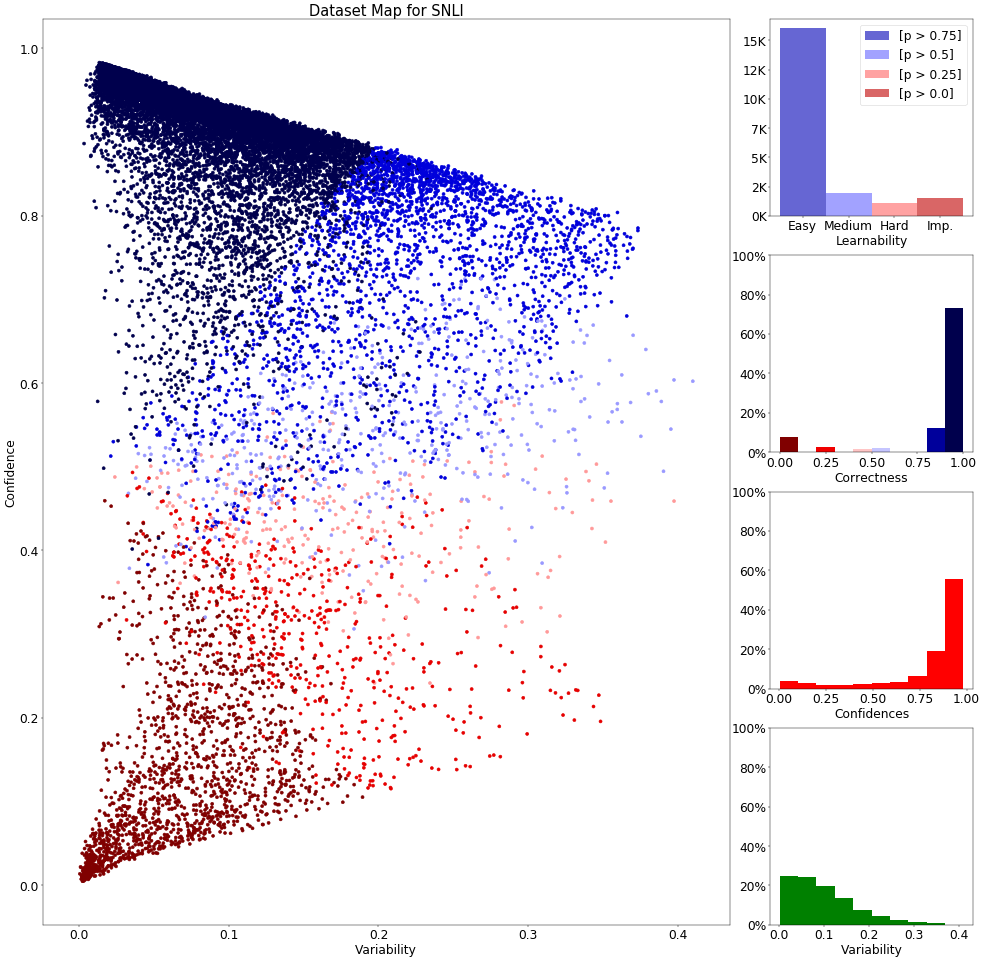

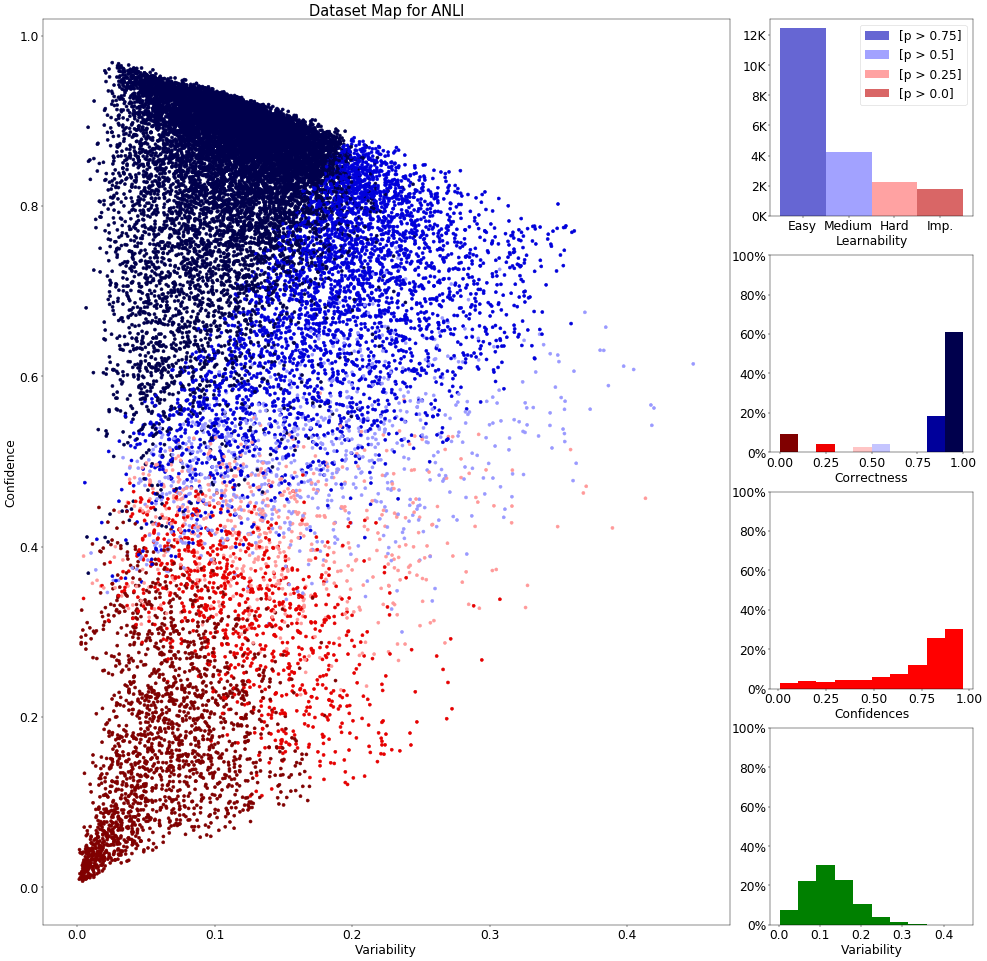

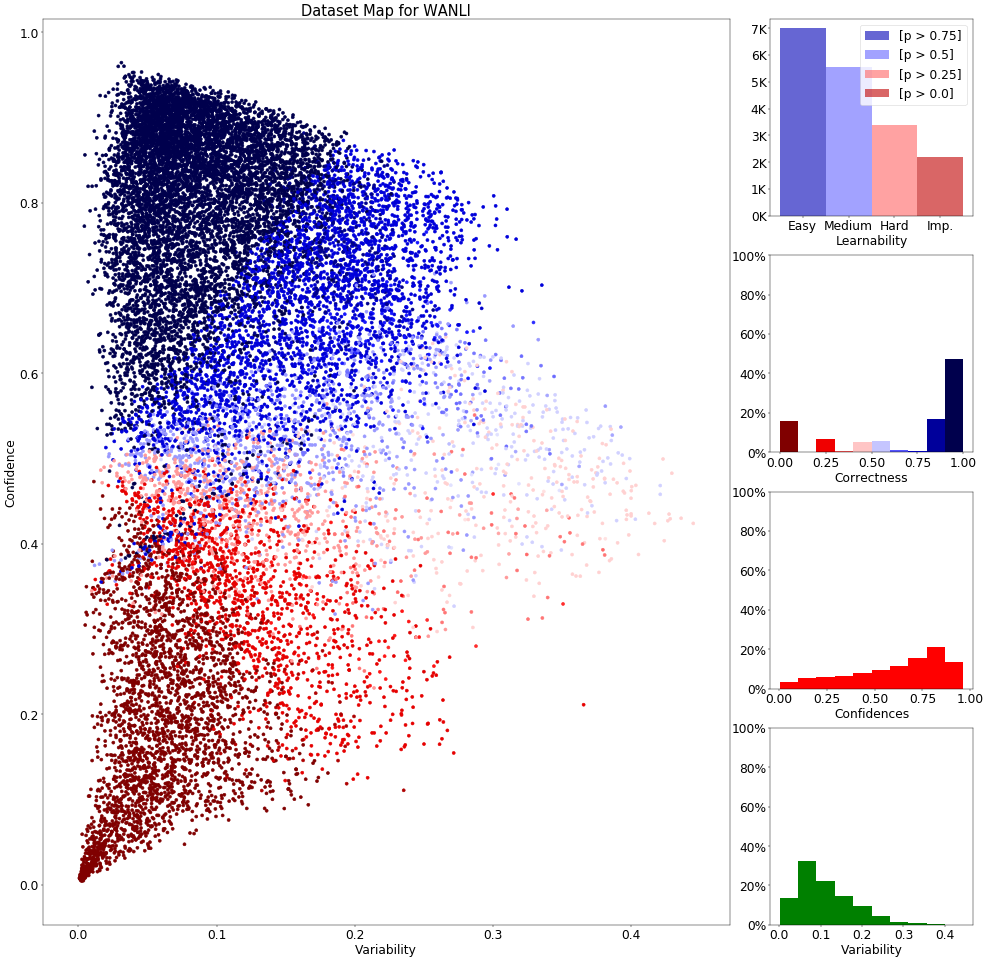

In [354]:
snli_map = datamap_subset(base_df=df, source_df=snli)
anli_map = datamap_subset(base_df=df, source_df=anli)
wanli_map = datamap_subset(base_df=df, source_df=wanli)

generate_dfs_2(snli_map, size=30, font_size=22)
generate_dfs_2(anli_map, size=30, font_size=22)
generate_dfs_2(wanli_map, size=30, font_size=22)

# Datamaps per Strategy

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


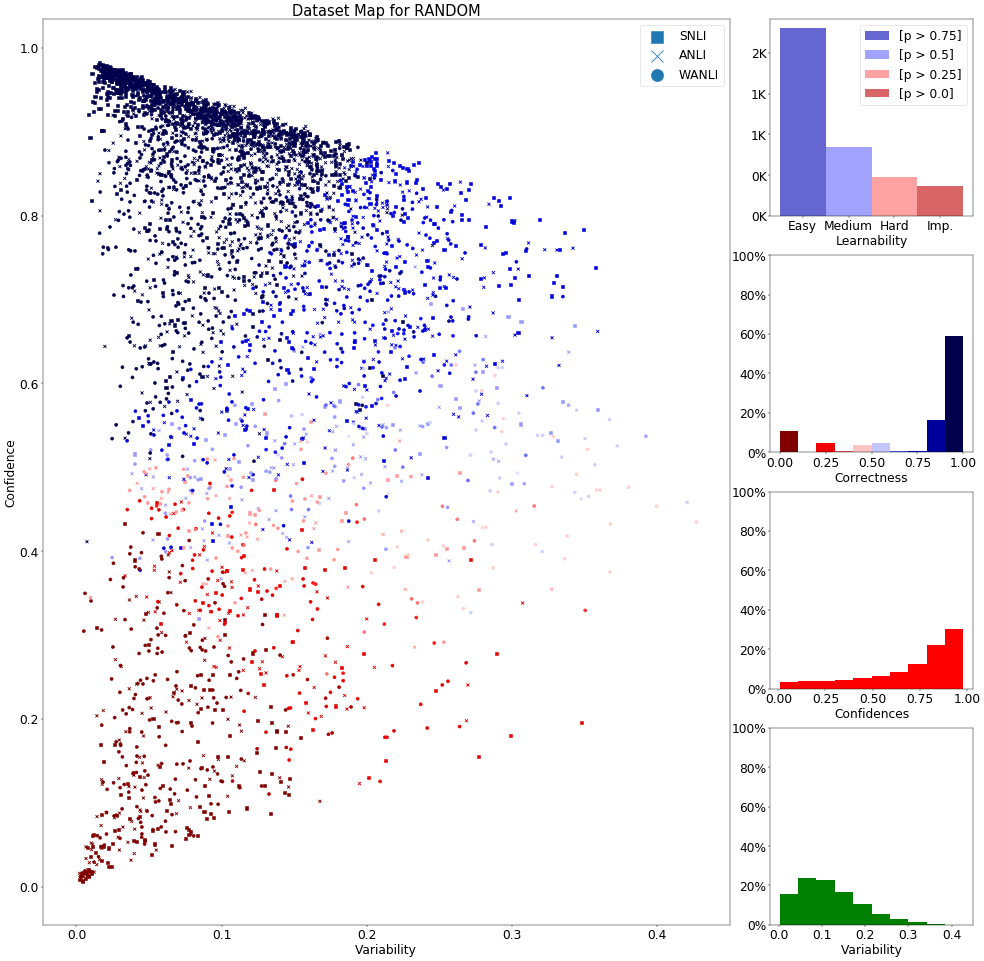

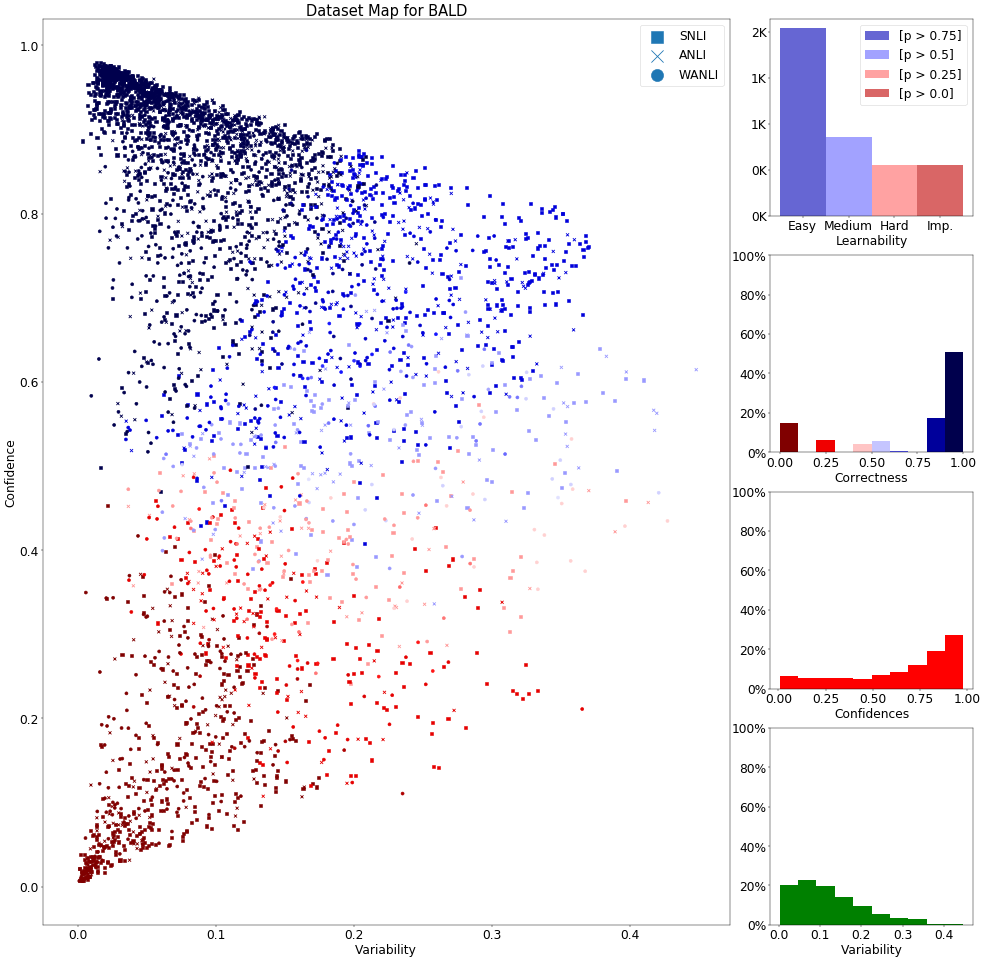

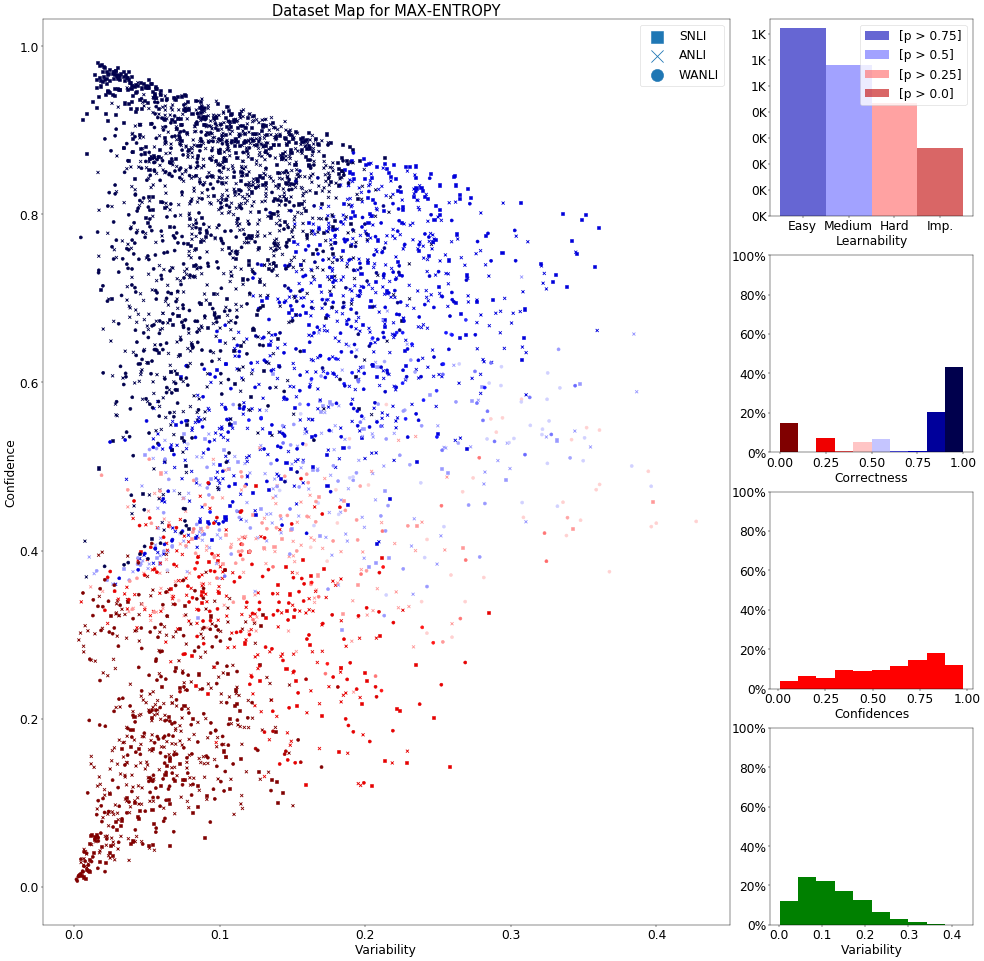

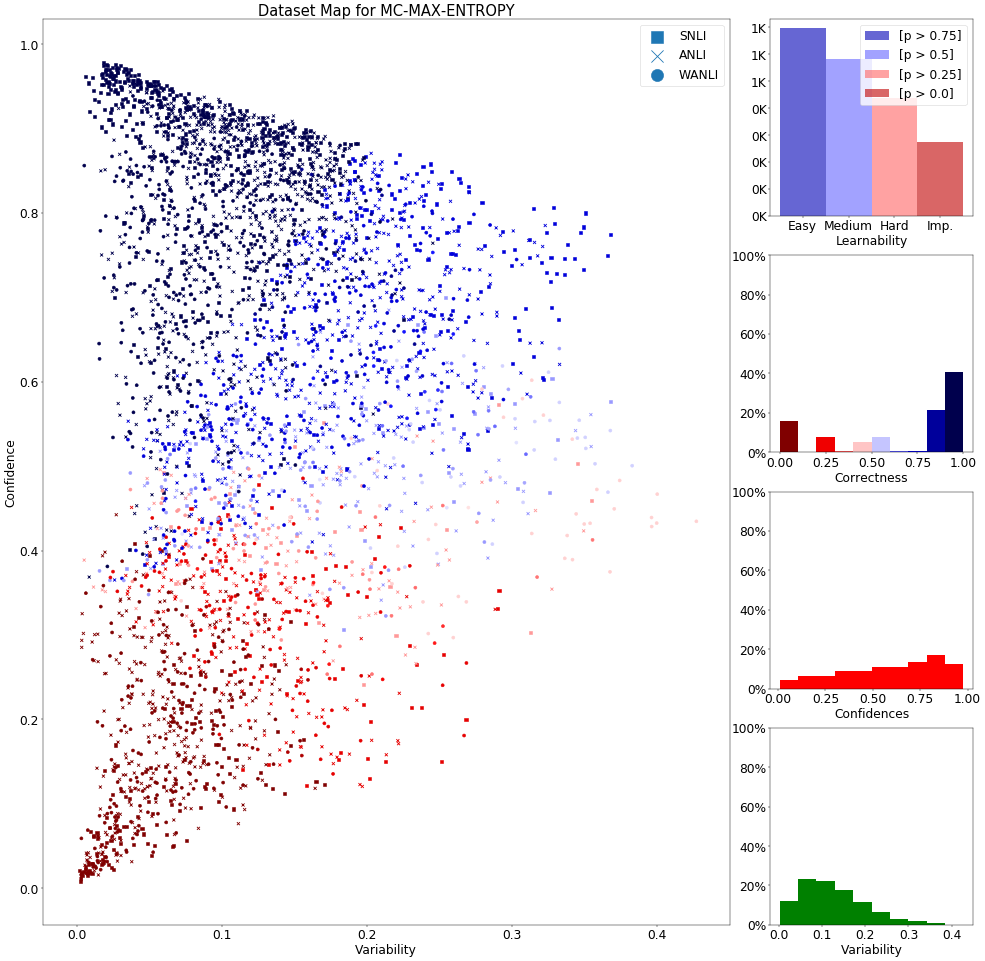

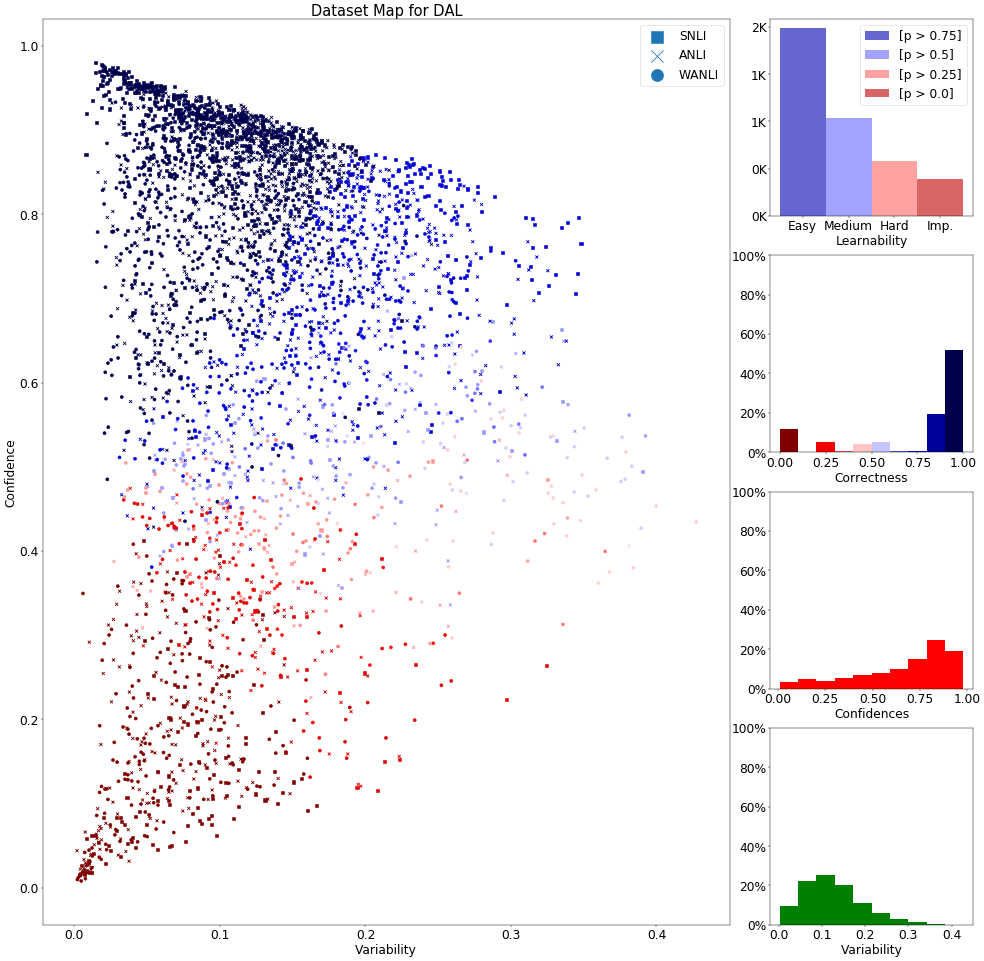

In [355]:
def get_subset_list(strategy_list):
    
    subset_list = []
    for strategy in strategy_list:
        
        strategy_df = load_strategy_acquisitions(strategy)
        
        id2dataset = {}
        for i in range(len(strategy_df)):
            row = strategy_df.iloc[i]
            id2dataset[row.ID] = row.Dataset
            
        strategy_subset = datamap_subset(base_df=df, source_df=strategy_df, name=strategy)
        strategy_subset['Dataset'] = strategy_subset['id'].apply(lambda x: id2dataset[x])
        subset_list.append(strategy_subset)
        
#     generate_dfs(subset_list, markers=True, size=100, n_bins=10)
    return subset_list 

subset_list = get_subset_list(['random', 'bald', 'max-entropy', 'mc-max-entropy', 'dal'])

# generate_dfs(subset_list, markers=True, size=100, n_bins=10)
for subset_map in subset_list:
    generate_dfs_2(subset_map, markers=True, size=30, font_size=22)

# Acquisitions by Difficulty over Time

In [ ]:
def generate_stacked_barchart(base_df, strategy_df, return_axs=False):
    
    number_of_examples = 500

    labels = []
    num_easy = []
    num_medium = []
    num_hard = []
    num_impossible = []

    easy_thresh = 0.75
    medium_thresh = 0.5
    hard_thresh = 0.25
    impossible_thresh = 0.0

    for active_round in range(1, strategy_df['round'].max()+1):

        acquisitions = strategy_df[strategy_df['round']==active_round]
        number_of_examples += len(acquisitions)
        labels.append(number_of_examples)

        confidences = base_df[base_df.id.isin(acquisitions.ID)]

        easy_mask = confidences.mean_conf > easy_thresh
        medium_mask = (confidences.mean_conf > medium_thresh) & (confidences.mean_conf < easy_thresh)
        hard_mask = (confidences.mean_conf > hard_thresh) & (confidences.mean_conf < medium_thresh)
        impossible_mask = (confidences.mean_conf > impossible_thresh) & (confidences.mean_conf < hard_thresh)

        num_easy.append(len(confidences[easy_mask]))
        num_medium.append(len(confidences[medium_mask]))
        num_hard.append(len(confidences[hard_mask]))
        num_impossible.append(len(confidences[impossible_mask]))

    fig, ax = plt.subplots(figsize=(20,20))
    plt.rcParams['figure.dpi'] = 40

    width = 210
    alpha = ALPHA

    num_easy = np.array(num_easy)
    num_medium = np.array(num_medium)
    num_hard = np.array(num_hard)
    num_impossible = np.array(num_impossible)
    labels = np.array(labels)

    cmap = mpl.cm.get_cmap(CMAP)


    ax.bar(labels, num_easy, width, label='Easy [p > {}]'.format(easy_thresh), color=cmap(1-0.85), alpha=alpha)
    ax.bar(labels, num_medium, width, bottom=num_easy, label='Medium [p > {}]'.format(medium_thresh), color=cmap(1-0.65), alpha=alpha)
    ax.bar(labels, num_hard, width, bottom=num_easy + num_medium, label='Hard [p > {}]'.format(hard_thresh), color=cmap(1-0.35), alpha=alpha)
    ax.bar(labels, num_impossible, width, bottom=num_easy + num_medium + num_hard, label='Impossible [p > {}]'.format(impossible_thresh), color=cmap(1-0.125), alpha=alpha)

    ax.set_xticks(ax.get_xticks()[2:])
    ax.set_ylabel('Acquisition by Difficulty')
    ax.set_xlabel('Number of Training Examples')
    ax.set_ylim(0, 260)
    ax.set_title(strategy_df['Name'].tolist()[0]+' - Acquisitions by Difficulty over Time')
    ax.legend(loc='lower right')
    
    if return_axs:
        
        return ax
    
    else:
        
        plt.plot(stacked=True)
        plt.show()

In [ ]:
strategy_ids = ['random', 'max-entropy', 'mc-max-entropy', 'dal', 'bald']
strategy_dfs = [load_strategy_acquisitions(strategy_id) for strategy_id in strategy_ids]

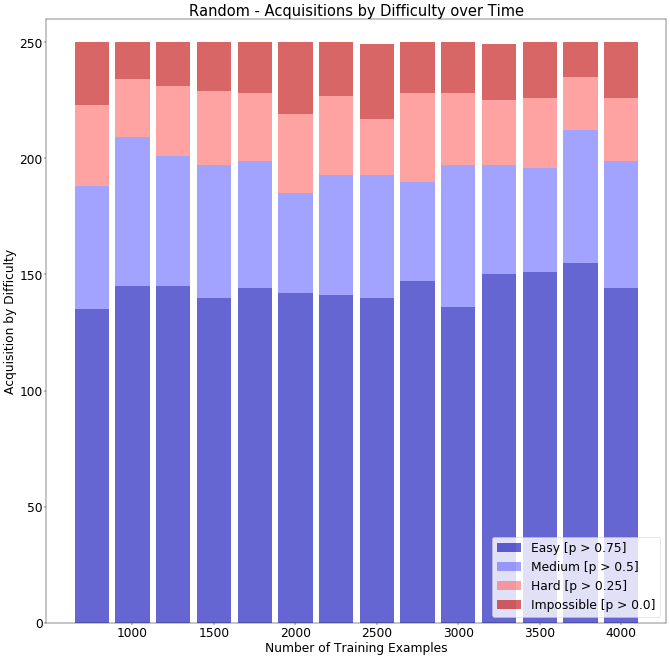

None


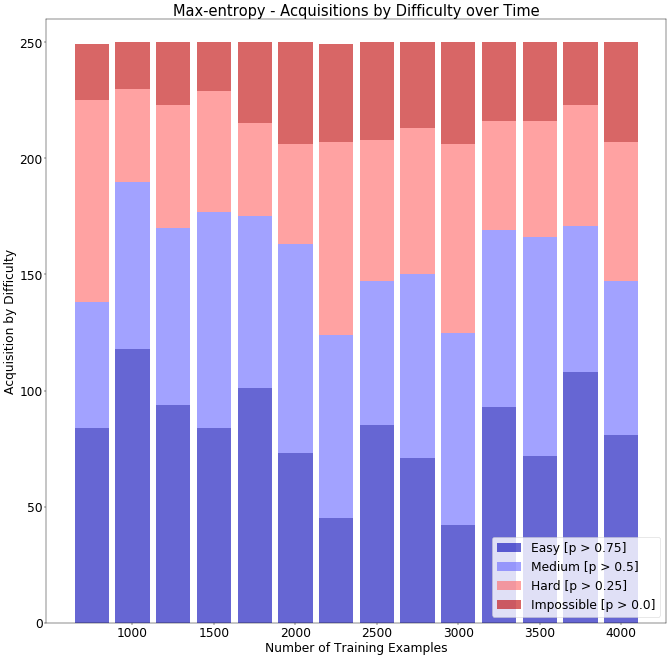

None


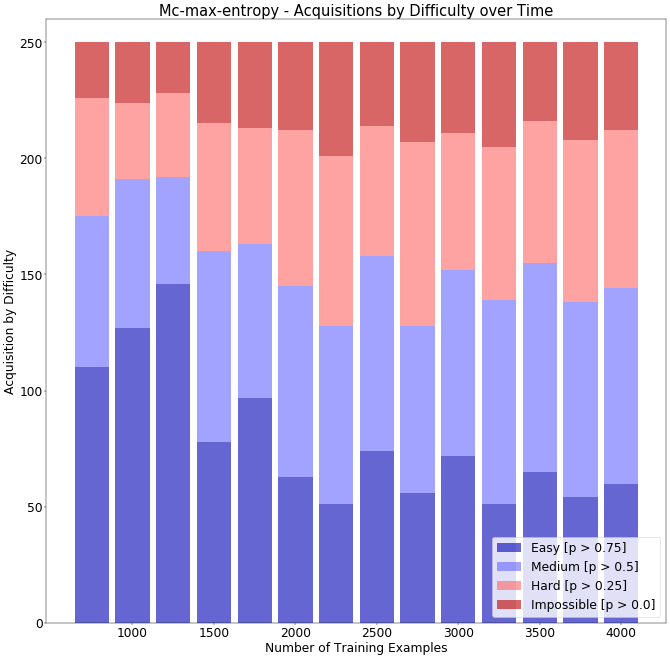

None


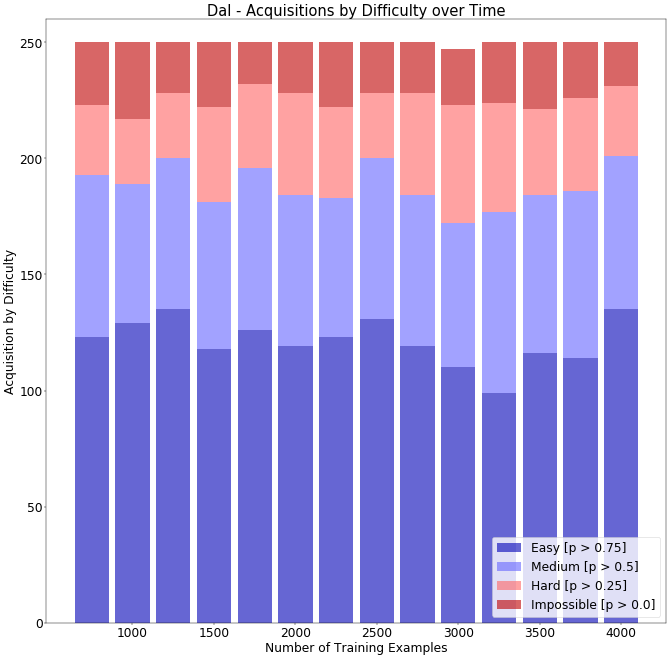

None


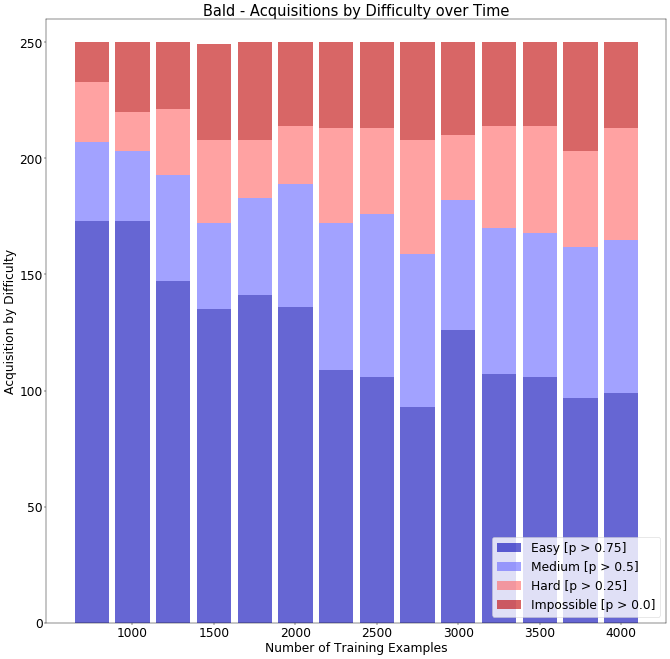

None


In [340]:
axs = []
for strategy_df in strategy_dfs:
    ax = generate_stacked_barchart(base_df=df, strategy_df=strategy_df, return_axs=False)
    print(ax)

# Examples of various difficulties:

In [366]:
EASY_THRESH = 0.75
MEDIUM_THRESH = 0.5
HARD_THRESH = 0.25
IMPOSSIBLE_THRESH = 0.0

COL_WIDTH = 25

def show_examples(source_df, source_map, num=5):
    
    difficulty_dict = {}
    
    easy_mask = source_map.mean_conf > EASY_THRESH
    medium_mask = (source_map.mean_conf > MEDIUM_THRESH) & (source_map.mean_conf < EASY_THRESH)
    hard_mask = (source_map.mean_conf > HARD_THRESH) & (source_map.mean_conf < MEDIUM_THRESH)
    impossible_mask = (source_map.mean_conf > IMPOSSIBLE_THRESH) & (source_map.mean_conf < HARD_THRESH)
    
    difficulty_dict['Easy'] = source_map[easy_mask]
    difficulty_dict['Medium'] = source_map[medium_mask]
    difficulty_dict['Hard'] = source_map[hard_mask]
    difficulty_dict['Impossible'] = source_map[impossible_mask]
    
    print('Examples from classes EASY, MEDIUM, HARD, and IMPOSSIBLE for {} \n'.format(source_map.Name.tolist()[0]))
    
    print('\nConfidence Thresholds:\nEasy: {}\nMedium: {}\nHard: {}\nImpossible: {}\n'.format(EASY_THRESH, MEDIUM_THRESH, HARD_THRESH, IMPOSSIBLE_THRESH))
    
    for key in difficulty_dict.keys():
        
        examples = source_df[source_df.ID.astype('str').isin(difficulty_dict[key].id.astype('string'))].head(num)
        
        print(str(key).capitalize() + ' examples:')
        examples = examples[['Premise', 'Hypothesis', 'Label']]
        examples['Hypothesis'] = examples['Hypothesis'].str.wrap(COL_WIDTH).astype('string')
        examples['Premise'] = examples['Premise'].str.wrap(COL_WIDTH).astype('string')
        
        examples = examples.style.set_properties(**{'text-align': 'left'})
        examples = examples.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
        display(examples)
   
show_examples(source_df=snli, source_map=snli_map, num=4)

Examples from classes EASY, MEDIUM, HARD, and IMPOSSIBLE for SNLI 


Confidence Thresholds:
Easy: 0.75
Medium: 0.5
Hard: 0.25
Impossible: 0.0

Easy examples:


,Premise,Hypothesis,Label
6,A boy is jumping on skateboard in the middle of a red bridge.,The boy skates down the sidewalk.,contradiction
106,A skier slides along a metal rail.,A skier is near the rail.,entailment
123,Closeup image of a dog swimming.,A cat reluctantly takes a bath.,contradiction
162,Children going home from school.,The children are at the library.,contradiction


Medium examples:


,Premise,Hypothesis,Label
80,"Two adults, one female in white, with shades and one male, gray clothes, walking across a street, away from a eatery with a blurred image of a dark colored red shirted person in the foreground.",Two adults walking across a road near the convicted prisoner dressed in red,neutral
314,"A man and a woman are standing next to sculptures, talking while another man looks at other sculptures.",Tall people standing,neutral
758,Children's soccer game being played while the sun sets in the background.,Girls playing soccer while the sun sets.,neutral
881,A group of people point forwards while performing some kind of act.,A group of people point somewhere while speaking.,neutral


Hard examples:


,Premise,Hypothesis,Label
140,A farmer fertilizing his garden with manure with a horse and wagon.,The man is in an open field with a horse and wagon.,neutral
141,A white horse is pulling a cart while a man stands and watches.,A horse is hauling goods.,neutral
328,A man squatting in the foreground of a photograph while taking a photograph of his own of a man doing a skateboarding kick flip in midair above a short flight of stairs outdoors.,Photographers capture a male skateboarder performing tricks inside an abandoned building.,contradiction
885,Group of people dancing,people dance together,entailment


Impossible examples:


,Premise,Hypothesis,Label
111,A skier in electric green on the edge of a ramp made of metal bars.,The skier was on the edge of the ramp.,neutral
112,A skier in electric green on the edge of a ramp made of metal bars.,The brightly dressed skier slid down the race course.,entailment
1070,A man wearing a red sweater is sitting on a car bumper watching another person work.,people make speed fast at speed breaker.,contradiction
1584,A blond child is pulling a wagon with a little blond boy in it.,A child is pulling a toy wagon.,entailment


# Uncertainty metric:

In [341]:
def compute_uncertainty(strategies):
    
    results = {key: [] for key in strategies}
    
    for seed in [42,43,44,45,46]:
        

        confidences = pd.read_pickle(path.format(seed))
        
        seed_entropies = {}
        
        sample_ids = list(confidences.keys())
        for sample_id in sample_ids:
    
            times_correct = []

            outputs = confidences[sample_id]
            output = outputs[-1] # last epoch
            
            prediction = output[0]
            pred_entropy = entropy(prediction)
            seed_entropies[sample_id] = pred_entropy
        
        def get_entropies(x):
            
            if x in seed_entropies.keys():
                return seed_entropies[x]
            else:
                return False
        
        for strategy in strategies:
            
            
            strategy_df = load_strategy_acquisitions(strategy, seed=seed)
            
            strategy_df['entropies'] = strategy_df.ID.apply(lambda x: get_entropies(x))
            uncertainty = np.mean(strategy_df.entropies.tolist())
            
            results[strategy].append(uncertainty)
        
    return results

uncertainty = compute_uncertainty(['random', 'bald', 'dal', 'max-entropy', 'mc-max-entropy'])

print('UNCERTAINTY METRIC FOR DIFFERENT STRATEGIES:')
for key in uncertainty.keys():
    print(key, 
          ':\n mean:', 
          np.mean(uncertainty[key]),
          ':\n std:', 
          np.std(uncertainty[key]))

UNCERTAINTY METRIC FOR DIFFERENT STRATEGIES:
random :
 mean: 0.14569755432101794 :
 std: 0.12006824717569374
bald :
 mean: 0.13631936818190954 :
 std: 0.14108747446771788
dal :
 mean: 0.16865564346966339 :
 std: 0.13558827287331457
max-entropy :
 mean: 0.19806842675337982 :
 std: 0.17714475736456495
mc-max-entropy :
 mean: 0.19286734788282076 :
 std: 0.18462011460014185
